#**PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation**

In this project, I have implemented the PointNet Model for Part Segmentation

**PointNet Paper** : [PointNet](https://arxiv.org/pdf/1612.00593v2.pdf)

**Dataset Download** : [Original Dataset](https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_v0.zip) / [Preprocessed Dataset](https://shapenet.cs.stanford.edu/media/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip)
                
I have used Preprocessed dataset in my code

**Special Note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import math
import json
import glob 
import gc
import time
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Downloading the Dataset

In [ ]:
# %cd /content/drive/MyDrive
# !wget --no-check-certificate https://shapenet.cs.stanford.edu/media/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
%cd /content
!unzip /content/drive/MyDrive/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip

## Loading the Dataset

In [4]:
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    pc = pc / m
    return pc

class PartNormalDataset(Dataset):
    def __init__(self,root = '/content/shapenetcore_partanno_segmentation_benchmark_v0_normal', npoints=2500, split='train', class_choice=None, normal_channel=False):
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.normal_channel = normal_channel


        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        self.cat = {k: v for k, v in self.cat.items()}
        self.classes_original = dict(zip(self.cat, range(len(self.cat))))

        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}
        # print(self.cat)

        self.meta = {}
        with open(os.path.join(self.root, 'train_test_split', 'shuffled_train_file_list.json'), 'r') as f:
            train_ids = set([str(d.split('/')[2]) for d in json.load(f)])
        with open(os.path.join(self.root, 'train_test_split', 'shuffled_val_file_list.json'), 'r') as f:
            val_ids = set([str(d.split('/')[2]) for d in json.load(f)])
        with open(os.path.join(self.root, 'train_test_split', 'shuffled_test_file_list.json'), 'r') as f:
            test_ids = set([str(d.split('/')[2]) for d in json.load(f)])
        for item in self.cat:
            # print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item])
            fns = sorted(os.listdir(dir_point))
            # print(fns[0][0:-4])
            if split == 'trainval':
                fns = [fn for fn in fns if ((fn[0:-4] in train_ids) or (fn[0:-4] in val_ids))]
            elif split == 'train':
                fns = [fn for fn in fns if fn[0:-4] in train_ids]
            elif split == 'val':
                fns = [fn for fn in fns if fn[0:-4] in val_ids]
            elif split == 'test':
                fns = [fn for fn in fns if fn[0:-4] in test_ids]
            else:
                print('Unknown split: %s. Exiting..' % (split))
                exit(-1)

            # print(os.path.basename(fns))
            for fn in fns:
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta[item].append(os.path.join(dir_point, token + '.txt'))

        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn))

        self.classes = {}
        for i in self.cat.keys():
            self.classes[i] = self.classes_original[i]

        # Mapping from category ('Chair') to a list of int [10,11,12,13] as segmentation labels
        self.seg_classes = {'Earphone': [16, 17, 18], 'Motorbike': [30, 31, 32, 33, 34, 35], 'Rocket': [41, 42, 43],
                            'Car': [8, 9, 10, 11], 'Laptop': [28, 29], 'Cap': [6, 7], 'Skateboard': [44, 45, 46],
                            'Mug': [36, 37], 'Guitar': [19, 20, 21], 'Bag': [4, 5], 'Lamp': [24, 25, 26, 27],
                            'Table': [47, 48, 49], 'Airplane': [0, 1, 2, 3], 'Pistol': [38, 39, 40],
                            'Chair': [12, 13, 14, 15], 'Knife': [22, 23]}

        # for cat in sorted(self.seg_classes.keys()):
        #     print(cat, self.seg_classes[cat])

        self.cache = {}  # from index to (point_set, cls, seg) tuple
        self.cache_size = 20000


    def __getitem__(self, index):
        if index in self.cache:
            point_set, cls, seg = self.cache[index]
        else:
            fn = self.datapath[index]
            cat = self.datapath[index][0]
            cls = self.classes[cat]
            cls = np.array([cls]).astype(np.int32)
            data = np.loadtxt(fn[1]).astype(np.float32)
            if not self.normal_channel:
                point_set = data[:, 0:3]
            else:
                point_set = data[:, 0:6]
            seg = data[:, -1].astype(np.int32)
            if len(self.cache) < self.cache_size:
                self.cache[index] = (point_set, cls, seg)
        point_set[:, 0:3] = pc_normalize(point_set[:, 0:3])

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        # resample
        point_set = point_set[choice, :]
        seg = seg[choice]

        return point_set, cls, seg

    def __len__(self):
        return len(self.datapath)

TRAIN_DATASET = PartNormalDataset(npoints=2048, split='trainval', normal_channel=False)
TEST_DATASET = PartNormalDataset(npoints=2048, split='test', normal_channel=False)
trainloader = torch.utils.data.DataLoader(TRAIN_DATASET, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
testloader = torch.utils.data.DataLoader(TEST_DATASET, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

## PointNet Model

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    new_y = torch.eye(num_classes)[y.cpu().data.numpy(),]
    if (y.is_cuda):
        return new_y.cuda()
    return new_y

class T_Net(nn.Module):
    def __init__(self, out):
        super(T_Net, self).__init__()
        # In : (batch_size, n, 3)

        self.conv1 = nn.Conv1d(out, 64, kernel_size = 1, stride = 1)
        self.batchnorm1 = nn.BatchNorm1d(64)

        # (batch_size, n, 64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size = 1, stride = 1)
        self.batchnorm2 = nn.BatchNorm1d(128)

        # (batch_size, n, 128)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size = 1, stride = 1)
        self.batchnorm3 = nn.BatchNorm1d(1024)

        # (batch_size, 1024)
        self.fc1 = nn.Linear(1024, 512)
        self.batchnorm4 = nn.BatchNorm1d(512)
        # (batch_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.batchnorm5 = nn.BatchNorm1d(256)
        # (batch_size, 512)
        self.fc3 = nn.Linear(256, out*out) # out = 3 if input transform, else out = 128 if feature transform
        self.relu = nn.ReLU()
        

    def forward(self, x):
    
        x = x.to(device)
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = self.relu(self.batchnorm4(self.fc1(x)))
        x = self.relu(self.batchnorm5(self.fc2(x)))
        x = self.fc3(x)

        out = int(math.sqrt(x.shape[1]))
        iden = Variable(torch.from_numpy(np.eye(out).flatten().astype(np.float32))).view(1, out * out).repeat(x.shape[0], 1)
        iden = iden.to(device)
        x = x + iden
        x = torch.reshape(x,(-1, out, out))
        return x

class PointNet(nn.Module):
    def __init__(self, tnet):
        super(PointNet,self).__init__()
        # In : (batch_size, n, 3)
        self.tnet1 = tnet(3)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.batchnorm1 = nn.BatchNorm1d(64)

        # (batch_size, n, 64)
        self.conv2 = nn.Conv1d(64, 128, 1) 
        self.batchnorm2 = nn.BatchNorm1d(128)

        # (batch_size, n, 128)
        self.conv3 = nn.Conv1d(128, 128, 1) 
        self.batchnorm3 = nn.BatchNorm1d(128)
        
        self.tnet2 = tnet(128)

        # (batch_size, n, 128)
        self.conv4 = nn.Conv1d(128, 512, 1)
        self.batchnorm4 = nn.BatchNorm1d(512)
        
        # (batch_size, n, 512)
        self.conv5 = nn.Conv1d(512, 2048, 1)
        self.batchnorm5 = nn.BatchNorm1d(2048)

        # (batch_size, 1088)        # We concatenate the global and local features
        self.conv6 = nn.Conv1d(4944 ,256, 1)
        self.batchnorm6 = nn.BatchNorm1d(256)

        # (batch_size, 512)        # We concatenate the global and local features
        self.conv7 = nn.Conv1d(256 ,256, 1)
        self.batchnorm7 = nn.BatchNorm1d(256)

        # (batch_size, 256)        # We concatenate the global and local features
        self.conv8 = nn.Conv1d(256 ,128, 1)
        self.batchnorm8 = nn.BatchNorm1d(128)

        # (batch_size, 128)
        self.conv9 = nn.Conv1d(128, 50, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x, label):

        x = x.to(device)
        out_tnet1 = self.tnet1(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, out_tnet1)
        x = x.transpose(2, 1)
        x = self.relu(self.batchnorm1(self.conv1(x)))
        out1 = x
        x = self.relu(self.batchnorm2(self.conv2(x)))
        out2 = x
        x = self.relu(self.batchnorm3(self.conv3(x)))
        out3 = x
        out_tnet2 = self.tnet2(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, out_tnet2)
        x = x.transpose(2, 1)
        x = self.relu(self.batchnorm4(self.conv4(x)))
        out4 = x
        x = self.batchnorm5(self.conv5(x))
        out5 = x
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 2048)
        x = torch.cat([x,label.squeeze(1)],1)
        x = x.view(-1, 2048+16, 1).repeat(1, 1, 2048)
        x = torch.cat((x, out1, out2, out3, out4, out5), 1)
        x = self.relu(self.batchnorm6(self.conv6(x)))
        x = self.relu(self.batchnorm7(self.conv7(x)))
        x = self.relu(self.batchnorm8(self.conv8(x)))
        x = self.conv9(x)
        x = x.transpose(2, 1).contiguous()
        x = F.log_softmax(x.view(-1, 50), dim=-1)
        x = x.view(batch_size, 2048, 50) # [B, N, 50]

        return x, out_tnet2

model = PointNet(T_Net).to(device)
model = model.apply(weights_init)

## Training


In [8]:
epoch_train_losses = []         
epoch_test_losses = []
epoch_val_losses = []             
accu_train_epoch = []
accu_test_epoch = []
accu_val_epoch = []

In [12]:
epochs = 20
lr = 0.001
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, eps=1e-08, weight_decay= 1e-4)

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

def criterion(pred, target, trans_feat):
        loss = F.nll_loss(pred, target)
        mat_diff_loss = feature_transform_regularizer(trans_feat)
        total_loss = loss + mat_diff_loss * 0.001
        return total_loss

def accuracy(y_pred, y):
    _, predicted = torch.max(y_pred, 1)
    # total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct/(batch_size*2048)

def make_tensor(tensor):
  if torch.cuda.is_available():
    return torch.cuda.FloatTensor(tensor)
  else:
    return torch.FloatTensor(tensor)


def train(model, dataset, optimizer, device):

    train_loss_batch = []
    accu_train_batch = []
    model.train()
    for idx,(data, labels, seg) in enumerate(dataset):
      
        optimizer.zero_grad()
        data = data.to(device)
        labels = labels.to(device)
        seg = seg.to(device)
        #Forward Pass
        data = data.float()
        labels = labels.long()
        seg = seg.long()
        data = data.transpose(2, 1)

        output, A = model(data, to_categorical(labels, 16))
        A = A.to(device)
        output = output.contiguous().view(-1, 50)
        seg = seg.view(-1, 1)[:, 0]
        pred_choice = output.data.max(1)[1]
        correct = pred_choice.eq(seg.data).cpu().sum()
        accu_train_batch.append(correct.item() / (32 * 2048))
        train_loss = criterion(output, seg, A)
        train_loss_batch.append(train_loss.item())
        # Backward
        train_loss.backward()
        optimizer.step()
    epoch_train_losses.append(sum(train_loss_batch)/len(dataset))
    accu_train_epoch.append(sum(accu_train_batch)/len(dataset))
    print(f"Train Epoch Loss: {sum(train_loss_batch)/len(dataset):.5f}   Train Epoch Accuracy: {sum(accu_train_batch)/len(dataset)*100:.5f}")

def val(model, dataset, device):
    
    val_loss_batch = []
    accu_val_batch = []
    model.eval()
    for idx,(data, labels, seg) in enumerate(dataset):
      with torch.no_grad():
        data = data.to(device)
        labels = labels.to(device)
        seg = seg.to(device)
        #Forward Pass
        data = data.float()
        labels = labels.long()
        seg = seg.long()
        data = data.transpose(2, 1)

        output, A = model(data, to_categorical(labels, 16))
        A = A.to(device)
        output = output.contiguous().view(-1, 50)
        seg = seg.view(-1, 1)[:, 0]
        pred_choice = output.data.max(1)[1]
        correct = pred_choice.eq(seg.data).cpu().sum()
        accu_val_batch.append(correct.item() / (32 * 2048))
        val_loss = criterion(output, seg, A)
        val_loss_batch.append(val_loss.item())
    epoch_val_losses.append((sum(val_loss_batch))/len(dataset))
    accu_val_epoch.append((sum(accu_val_batch))/len(dataset))
    print(f"Val Epoch Loss: {(sum(val_loss_batch))/len(dataset):.5f} Val Epoch Accuracy: {(sum(accu_val_batch))/len(dataset)*100:.5f}")

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_valid_loss = float('inf')
if os.path.isfile("/content/drive/MyDrive/PointNet.pt"):
    checkpoint = torch.load('/content/drive/MyDrive/PointNet.pt', device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_valid_loss = checkpoint['loss']
print(best_valid_loss)
for epoch in range(epochs):
    
    start_time = time.monotonic()
    print(f"Epoch: {epoch + 1}")
    train(model, trainloader, optimizer, device)
    val(model, testloader, device)
    if best_valid_loss > epoch_val_losses[-1]:
      best_valid_loss = epoch_val_losses[-1]
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_val_losses[-1],
            }, '/content/drive/MyDrive/PointNet_Best.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()
    print("\n\n\n TIME TAKEN FOR THE EPOCH: {} mins and {} seconds".format(epoch_mins, epoch_secs))
    

print("OVERALL TRAINING COMPLETE")

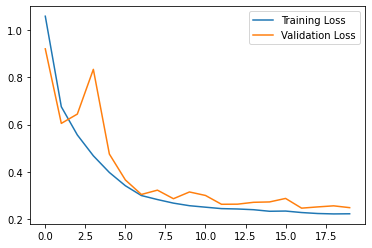

In [11]:
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.legend()
plt.show()

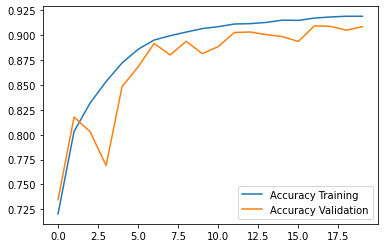

In [12]:
plt.plot(accu_train_epoch, label='Accuracy Training')
plt.plot(accu_val_epoch, label='Accuracy Validation')
plt.legend()
plt.show()

## Testing

In [ ]:
for idx,(data, labels, seg) in enumerate(testloader):

    data = data.to(device)
    labels = labels.to(device)
    seg = seg.to(device)
    print(data.shape)
    #Forward Pass
    data = data.float()
    labels = labels.long()
    seg = seg.long()
    data = data.transpose(2, 1)

    output, A = model(data, to_categorical(labels, 16))
    data = data.transpose(2, 1)
    point_cloud = data
    k = 5
    xyz=data[k,:,:]
    xyz = torch.reshape(xyz, (xyz.shape[1], xyz.shape[0]))
    xyz = xyz.cpu().detach().numpy()
    _, out_seg = torch.max(output, 2)
    out = out_seg[k, :]
    rgb = np.zeros(shape=[2048, 3])
    partid = [[0, 1, 2, 3], [4, 5], [6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23], [24, 25, 26, 27], [28, 29], [30, 31, 32, 33, 34, 35], [36, 37], [38, 39, 40], [41, 42, 43], [44, 45, 46], [47, 48, 49]]
    unique = torch.unique(out).tolist()
    for i in range(2048):
        if out[i] == unique[0]:
            rgb[i,:] = [1, 0, 0]
        elif out[i] == unique[1]:
            rgb[i,:] = [0, 1, 0]
        elif out[i] == unique[2]:
            rgb[i,:] = [0, 0, 1]
        elif out[i] == unique[3]:
            rgb[i,:] = [1, 0.5, 1]
        elif out[i] == unique[4]:
            rgb[i,:] = [0, 1, 1]
        elif out[i] == unique[5]:
            rgb[i,:] = [1, 1, 0]
        else:
            rgb[i,:] = [0.5, 0.5, 0.5]
        #print(rgb)
    ax = plt.axes(projection='3d')
    xyz = xyz.reshape((2048, 3))
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c = rgb)
    plt.grid(False)
    plt.axis('off')
    plt.show()
    break